Transport phenomena is the study of the transferring of momentum, energy and mass. Oftentimes these processes are coupled as in boiling water, where bubbles of air trapped in the water nucleate due to the elevated temperature reducing the solubility of gases, followed by the density differences between the bubble and water causing the bubble to rise. These processes are further mediated through convection currents caused by temperature gradients in the boiling water. 

In this example, we will look at a far simple example of energy transport, characterized as the change in temperature of a heat source placed in an infinitely large cooler surrounding region. A visualization is shown in the figure below, where the red and blue regions indicate hot and cold areas respectively. Periodic boundary conditions will be assumed to overcome the limitation of finite sizes in compute.  

<img src="visualizations/system_setup.png" alt="drawing" width="500"/>

https://www-udc.ig.utexas.edu/external/becker/teaching/557/problem_sets/problem_set_fd_explicit.pdf

# Theory

For our problem, we will be basing our grid on rectilinear or cartesian coordinates. First, we will review the relevant transport equations. A more detailed explanation of each expression and derivation can be found in BSLK. We begin by writing a general energy transport equation through a control volume.

$$ change = accumulation + removal + generation + destruction $$

In our closed system, there is no generation, destruction and accumulation of energy, meaning that the change in energy over time can be written as

$ change = removal$

If we approximate that the energy lost from the addition of heat is lost through conduction, the removal of energy can be approximated using fourier's law, defined as 

$$ q = -k \nabla T $$

where $k (\frac{W}{mK})$ is the thermal conductivity of the matrix, $\nabla T (\frac{K}{m})$ is the temperature gradient between the heated area and its surroundings and $q (\frac{W}{m^2 K})$ is the heat flux through a surface. This is related to the energy change at each grid point over time as, 

$\frac{d E}{dt} = \nabla q$

Where $E (\frac{J}{m^3})$ is the energy density of a specific grid point and $t (s)$ is the time. This leads to the expression, 

$$ \frac{d E}{d t} = -k \nabla^2 T $$

The energy density of the heat source can be expressed from the heat capacity of the heat source, defined as $E = \rho c_p (T - T_{ref})$. If we make the further approximation that density $\rho (\frac{kg}{m^3})$ and specific heat capacity $\frac{J}{K kg}$ stay constant with temperature, we can rearrange the above expression to obtain the following PDE written as a function of temperature exclusively,

$$ \frac{dT}{dt} = -\frac{k}{\rho c_p} \nabla^2 T$$

Oftentimes, the factor $\frac{k}{\rho c_p}$ is condensed into the term $\alpha (\frac{m^2}{s})$ defining the thermal diffusivity of the system and will be used as an input parameter.

Now that we have laid out the basic theory being implemented, we shall turn to how we can convert math to something a computer can solve. There are derivatives of time and space that we will need to solve for. I will stick to the simplest ones here as the focus is on creating an illustration how the code looks different between implementations in different languages. However, the literature of how both are done is vast with (SOURCES PROVIDED).

## Finite difference

The simplest way to discretize a differential equation in space is using a finite difference technique. The core idea of this scheme is we convert the continous differential equations above into discrete sums and differences which we can solve. Below is a visualization as to what we do in a finite difference scheme. The grid is discretized into the points shown, and the red and blue regions are areas of high and low temperature.

<img src="visualizations/FDM_viz.png" alt="drawing" width="500"/>

$\Delta x$ and $\Delta y$ are the grid spacings in the $x$ and $y$ direction respectively. The derivatives are then expressed as a function of adjacent points. Commonly, this is done using a central difference scheme shown below for the first $f^1_x$ and second derivative $f^2_x$ for a function $f(x,y,t)$

\begin{align}
f^1_x &= \frac{f(x + \Delta x, y, t) - f(x - \Delta x, y, t)}{2\Delta x} \\
f^2_x &= \frac{f(x + \Delta x, y, t) - 2f(x,y,t) + f(x - \Delta x, y, t)}{\Delta x^2} 
\end{align}

The central difference discretization scheme produces second order error compared to forward or backward difference which produce first order error. 

## Forward Euler

Now that the derivative over space is explained, I explain how we perform timestepping or time integration. Time integration schemes  are split into explicit and implicit scheme categories. Explicit schemes include techniques such as Forward Euler and the Runge-Kutta time integrators while implicit schemes include the Backwards Euler and Crank-Nicholson schemes. Both categories solve for the dynamics of the system given an initial state of the system. For now, we will stick to the Forward Euler technique. Notationally, this looks like

\begin{align}
g(x, y, t_0) &= b \\
\frac{dg}{dt} &= f(x,y,t) \\
g(x, y , t + \Delta t) &= g(x, y, t) + \Delta t \frac{dg}{dt}
\end{align}

where $g(x, y, t)$ is a value of a function at time $t$ and location $(x,y)$, $\frac{dg}{dt}$ is the derivative of function $g$ with respect to time $t$ and is expressed as any function $f(x,y,t)$. The value of $g(x, y, t + \Delta t)$ is a sum of the value of $g(x, y, t)$ and the timestep over which the derivative $\frac{dg}{dt}$ is calculated.

The Forward Euler technique can be numerically unstable. Therefore care must be taken when selecting parameters for time and space integration and must fall within the CFL condition, defined as $C = \frac{u \Delta t}{\Delta x} < 1$. In this case as we do not have advection we will be using the CFL condition as defined from the thermal diffusivity, defined as $C = \frac{\alpha \Delta t}{\Delta x^2}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import glob

import src.FD_helper.visualization as visualize
import src.FD_helper.forward_euler_1D as FD_1D
import src.FD_helper.forward_euler_2D as FD_2D

figheight = 5

## Python implementation

Using the established rules above, we move to generating a prototype in python. One could easily use [`scipy.integrate`](https://docs.scipy.org/doc/scipy/reference/integrate.html#solving-initial-value-problems-for-ode-systems) to access many of the time integration schemes used, but for the purpose of this exercise I will code everything up myself. `fun` used in [`scipy.integrate`](https://docs.scipy.org/doc/scipy/reference/integrate.html#solving-initial-value-problems-for-ode-systems) would be our spatial discretization using the central difference method. 

A 1D implementation is first shown to demonstrate the conceptual structure of the code. A heat source is placed in the middle of the system of length $L$, with periodic boundary conditions placed at each edge.

### 1D version

In [2]:
## EDIT THIS ##
L = 256
dx = 1/L
hot_point = 64
halo = 1

dt = 0.0002
timesteps = 10000
dump_freq = 100

T_cold = 273
T_hot = 280
alpha = 0.002

bc_type = FD_1D.BoundaryType.PERIODIC

T_l = 275 # only does something if boundary type if set to constant_value
T_r = 275 # only does something if boundary type if set to constant_value
## EDIT THIS ##

C = alpha/(dx**2/dt)
if C > 1:
    raise RuntimeWarning("CFL condition not fulfilled")

In [3]:
# creating data structures
rod_old = FD_1D.make_system(L, hot_point, T_hot, T_cold)

# inserting halo regions
rod_old = np.insert(rod_old, 0, 0)
rod_old = np.insert(rod_old, L+1, 0)

rod_new = rod_old.copy()
total_E = np.empty(timesteps + 1)

output_temperatures = np.empty((timesteps//dump_freq+1, L))
output_length = np.empty((timesteps//dump_freq+1, L))

for t in range(0, timesteps + 1):
    rod_old = FD_1D.apply_boundary(rod_old, bc_type, T_left=T_l, T_right=T_r, halo=halo)

    if t%dump_freq == 0:
        idx = t//dump_freq
        output_temperatures[idx] = rod_old[1:L+1]
        output_length[idx] = np.arange(0, L)
    
    rod_new = FD_1D.FD_timestep(rod_old, dx, dt, alpha, halo)

    total_E[t] = np.sum(rod_new[1:L])

    rod_old = rod_new.copy()

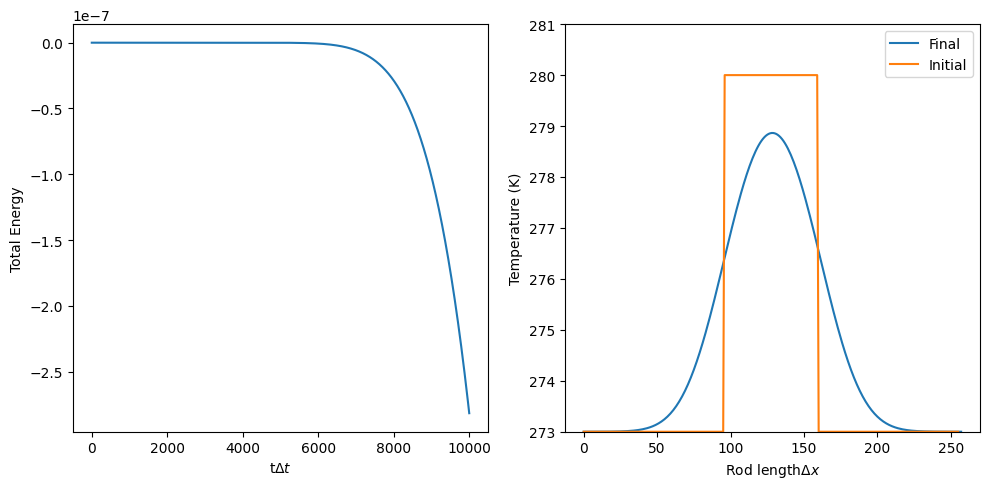

In [5]:
ar = 1
fig, axs = plt.subplots(1, 2, figsize = (2*figheight*ar, figheight))

ax = axs[0]
ax.plot((total_E- total_E[0])/total_E[0]*100)

ax.set_ylabel("Total Energy")
ax.set_xlabel("t"+r"$\Delta t$")

ax = axs[1]
rod_original = FD_1D.make_system(L, hot_point, T_hot, T_cold)
ax.plot(rod_new, label = "Final")
ax.plot(rod_original, label = "Initial")
ax.set_ylim([T_cold, T_hot+1])


ax.set_ylabel("Temperature (K)")
ax.set_xlabel("Rod length"+r"$\Delta x$")
ax.legend()

fig.tight_layout()

The left plot shows the evolution of total system energy over time (normalized by the initial value), demonstrating near conservation initially followed by gradual energy loss at later times, indicative of discretization related errors. However these changes are near machine precision, indicating that we can disregard the effect on dynamics that these changes in energy may have. The right plot illustrates the temperature profile along the rod at the initial and final states. Initially, the temperature is localized in a hot square pulse at the center. Over time, thermal diffusion smooths the profile into a broader distribution.

Now that we have shown a succesful implementation in 1D, lets up the difficulty somewhat and move to 2D

### 2D version

In [2]:
## CHANGE THESE ##
nx = 256
ny = 256
# keep square for now (nx == ny)
Lx = nx//4
Ly = ny//4
bc = FD_2D.BoundaryType.PERIODIC

dt = 0.000025
timesteps = 10000
dump_freq = 100

alpha = 0.01
T_h = 373 # temperature of hot region
T_c = 273 # temperature of cold region

T_l = 275 # temperature of left wall
T_r = 275 # temperature of right wall
T_t = 275 # temperature of top wall
T_b = 275 # temperature of bottom wall
## CHANGE THESE ##

halo = 1
dx = 1/nx
dy = 1/ny
C = alpha/(min(dx, dy)**2/dt)
if C > 0.1:
    raise RuntimeWarning("CFL condition not fulfilled")

In [3]:
grid_old = FD_2D.make_system_square(nx+2*halo, ny+2*halo, Lx, Ly, T_h, T_c)
grid_new = np.empty((nx+2*halo, ny+2*halo))

temperature_fields_time = np.empty((timesteps//dump_freq+1, nx, ny))
times = np.empty(timesteps//dump_freq+1)
total_E = np.empty(timesteps//dump_freq+1)

for time in range(0, timesteps+1):
    grid_old = FD_2D.apply_boundary(grid_old, bc, T_left=T_l, T_right=T_r, T_top = T_t, T_bottom = T_b, halo=halo)

    if time%dump_freq == 0:
        temperature_fields_time[time//dump_freq] = grid_old[halo:nx+halo, halo:ny+halo]
        times[time//dump_freq] = time
        total_E[time//dump_freq] = np.sum(grid_old[halo:nx-halo,halo:ny-halo])
    
    grid_new = FD_2D.FD_timestep(grid_old, dx, dy, dt, alpha, halo)

    grid_old = grid_new.copy()

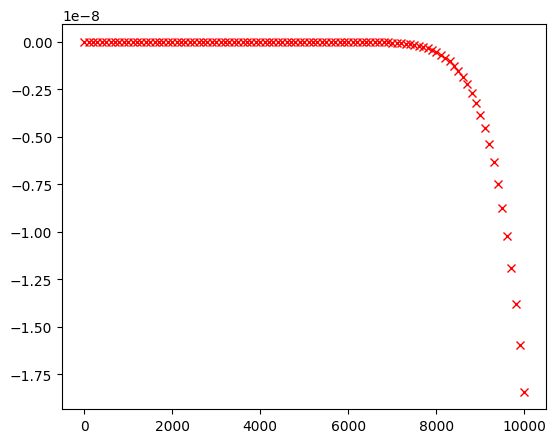

In [4]:
ar = 1.25
fig, ar = plt.subplots(1, 1, figsize = (ar*figheight, figheight))
plt.plot(times, (total_E-total_E[0])/total_E[0]*100, "rx")

This plot shows the change in total energy over time for a 2D heat diffusion simulation using the implemented FDM scheme. The vertical axis represents the deviation of the system's total thermal energy from its initial value, and the horizontal axis represents time in discrete steps. The energy remains nearly constant although at later times, a small energy loss is observed. The magnitude of these differences being near machine precision indicate this behavior is attributable to accumulation of floating point roundoff and it not inherent to the technique. 

**Things to try**
1. Play around with different parameters(nx, ny, dt, alpha) and see when the simulation becomes numerically unstable

In [5]:
ani = visualize.animate_colormap(temperature_fields_time, times = times, update_lims = False)
HTML(ani.to_jshtml())

We can see how the initial square of heat in the center of the domain begins to become circular, followed by a reduction in temperature from the outside in.

# Single core implementation in C++

Now that we have the base in python, lets implement the FD technique in C++. This section will use various `std` libraries in C++ but will omit MPI at the moment. We will be using pass by reference, although pass by value to more closely align with the python code can also be done, if slower.

You can play around with the settings of the implementation by editing the system through the sample inputs in the `main` function in `main.cpp`

```
// INPUT PARAMETERS
int nx = 1024; // size of field in x direction
int ny = 1024; // size of field in y direction

double dt = 0.000025; // timestep length 
double timesteps = 10000; // number of timesteps
int dump_freq = 10000; // Timesteps between data dump

double alpha = 0.002; // Thermal diffusivity of system
double T_hot = 373.0; // Temperature in K of the hot point
double T_cold = 273.0; // Temperature in K of the cold point
// INPUT PARAMETERS
```

Recompile and run once settings are changed to see them reflected in the simulation with these instructions.

```
make clean
make
./heat_solver
```

In [ ]:
path = "src/single_core"
data_paths = sorted(glob.glob(f"{path}/T*.txt"))
total_E = np.empty(len(data_paths))
times = np.empty(len(data_paths), dtype = int)
raw_data = []

for i, path in enumerate(data_paths):
    time = int(path.split("/")[-1].split("_")[-1].split(".")[0])
    data = visualize.read_data(path)

    times[i] = time
    raw_data.append(data)
    total_E[i] = np.sum(data)

raw_data = np.array(raw_data)

In [ ]:
ar = 1.25
fig, ax = plt.subplots(1, 1, figsize = (ar*figheight, figheight))

ax.plot(times, total_E/total_E[0], 'rx')
ax.set_ylabel(r"$\frac{E(t)}{E_0}$")
ax.set_xlabel(r"$t \Delta t$")

The implementation conserves energy to machine precision as expected.

In [ ]:
ani = visualize.animate_colormap(raw_data, times = times, update_lims = False)
HTML(ani.to_jshtml())

As in the 2D python implementation, the initial square of heat in the center of the domain begins to become circular, followed by a reduction in temperature from the outside in.

# Multicore (CPU) implementation in C++

2 main ways to perform compute on multiple cores are available. They are openMP and MPI based techniques. These differ on how memory is allocated between processors, which also impacts the scalability and performance of each based on system size and allocated resources. openMP uses shared memory to remove the need for message passing but is only supported by systems that share memory. MPI supports parallel computation for systems with distributed or shared memory as each process is executes independently from one another.

For personal computers, openMP offers a simple way to add parallelism without needing to resort to the extra preparation and planning needed to write and execute MPI based code at the expense of less flexibility if wanting to use HPC compute clusters such as the DoE's Frontier, Aurora or Perlmutter. 

Please read the source of my knowledge on this topic, the fantastic textbook "Parallel Programming in C with MPI and OpenMP" by Michael J. Quinn. It may be slightly outdated given its 20+ years old, but it holds great information on the topic. I'm still learning new content as I read this textbook.

## OpenMP

This section is based on chapter 17 in the textbook "Parallel Programming in C with MPI and OpenMP" by Michael J. Quinn.

You can play around with the settings of the implementation by editing the system through the sample inputs in the `main` function in `main.cpp`

```
// INPUT PARAMETERS
const int threads = 2;
int nx = 1024; // size of field in x direction
int ny = 1024; // size of field in y direction

double dt = 0.000025; // timestep length 
double timesteps = 10000; // number of timesteps
int dump_freq = 10000; // Timesteps between data dump

double alpha = 0.002; // Thermal diffusivity of system
double T_hot = 373.0; // Temperature in K of the hot point
double T_cold = 273.0; // Temperature in K of the cold point
// INPUT PARAMETERS
```

Recompile and run once settings are changed to see them reflected in the simulation with these instructions.

```
make clean
make
./heat_solver
```

In [ ]:
path = "src/open_MP"
data_paths = sorted(glob.glob(f"{path}/T*.txt"))
total_E = np.empty(len(data_paths))
times = np.empty(len(data_paths), dtype = int)
raw_data = []

for i, path in enumerate(data_paths):
    time = int(path.split("/")[-1].split("_")[-1].split(".")[0])
    data = visualize.read_data(path)

    times[i] = time
    raw_data.append(data)
    total_E[i] = np.sum(data)

raw_data = np.array(raw_data)

In [ ]:
ar = 1.25
fig, ax = plt.subplots(1, 1, figsize = (ar*figheight, figheight))

ax.plot(times, total_E/total_E[0], 'rx')
ax.set_ylabel(r"$\frac{E(t)}{E_0}$")
ax.set_xlabel(r"$t \Delta t$")

Energy is conserved to machine precision.

In [ ]:
ani = visualize.animate_colormap(raw_data, times = times, update_lims = False)
HTML(ani.to_jshtml())

## OpenMPI

You can play around with the settings of the implementation by editing the system through the sample inputs in the `main` function in `main.cpp`

```
// INPUT PARAMETERS
int nx = 1024; // size of field in x direction
int ny = 1024; // size of field in y direction

double dt = 0.000025; // timestep length 
double timesteps = 10000; // number of timesteps
int dump_freq = 10000; // Timesteps between data dump

double alpha = 0.002; // Thermal diffusivity of system
double T_hot = 373.0; // Temperature in K of the hot point
double T_cold = 273.0; // Temperature in K of the cold point
// INPUT PARAMETERS
```

Recompile and run once settings are changed to see them reflected in the simulation with these instructions.

```
make clean
make
mpirun -n {n-cores} heat_solver
```

In [ ]:
path = "src/MPI"
data_paths = sorted(glob.glob(f"{path}/T*.txt"))
total_E = np.empty(len(data_paths))
times = np.empty(len(data_paths), dtype = int)
raw_data = []

for i, path in enumerate(data_paths):
    time = int(path.split("/")[-1].split("_")[-1].split(".")[0])
    data = visualize.read_data(path)

    times[i] = time
    raw_data.append(data)
    total_E[i] = np.sum(data)

raw_data = np.array(raw_data)

In [ ]:
ar = 1.25
fig, ax = plt.subplots(1, 1, figsize = (ar*figheight, figheight))

ax.plot(times, total_E/total_E[0], 'rx')
ax.set_ylabel(r"$\frac{E(t)}{E_0}$")
ax.set_xlabel(r"$t \Delta t$")

Energy is conserved to machine precision.

In [ ]:
ani = visualize.animate_colormap(raw_data, times = times, update_lims = False)
HTML(ani.to_jshtml())

# Scaling

The objective of any parallelized implementation is to reduce compute time. However, will this implementation succeed in this endeavour? To check whether it does, this section will analyze the strong and weak scaling. 

Strong scaling, compared against Amdahl's law, is measured through calculating the runtime as more resources are provided at the same system size. Broadly speaking, a system is said to scale strongly if there is a linear relationship between the observed speedup and the increase in the number of resources allocated. An expression commonly used to characterize this relationship is,

$$ S(n) = \frac{1}{(1 - P) + \frac{P}{n}} $$

Where $S$ is the speedup, $P$ is the proportion of the program that is parallelizable and $n$ is the number of cores or threads.

Weak scaling, compared against Gustafson's law, is measured through calculating the runtime as system size grows proportional with the resources allocated. A system can be said to scale weakly if there is a linear relationship between the increase in system size and the resources allocated to the program. An expression commonly used to characterize this relationship is

$$ S(n) = (1 - P) + Pn $$

To minimize the impact that writing output data has on the runtime, I only output data at the start and end of the simulation. I calculate the time taken for each part of the code using the following abbreviations

| Abbreviation | Measurement |
| :--: | :--: |
| IO | Time taken to write data |
| TS | Time taken for timestepping |
| BC | Time taken to perform boundary conditions |
| MP | Time taken to perform message passing |
| Tot | Total runtime |

My device uses an Intel i5 1345U with 8 E cores and 2 P cores. Each P core has 2 threads, limiting the maximum number of threads and cores I can use to 2 each. The performance of the code will vary depending on your system. The mean and standard deviation of runtimes are obtained from 3 runs in all scenarios.

## OpenMP

### Strong scaling

Strong scaling is compared to in this section using a $1024^2$ system size run for $10^4$ timesteps. I will further breakdown the time taken for each part of the simulation based on the classification shown above. 

| Threads | TS (s) | BC (s) | IO (s) | Total (s) |
| :---:| :---: | :---: | :---: | :---: |
| 1 | 20.1259 $\pm$ 0.2374 | 0.1582 $\pm$ 0.0008 | 0.3890 $\pm$ 0.0027 | 20.6819 $\pm$ 0.2413 |
| 2 | 11.5238 $\pm$ 0.3688 | 0.1025 $\pm$ 0.0073 | 0.3881 $\pm$ 0.0038 | 12.0228 $\pm$ 0.3783 |

Speed up observed is approximately 41.8 \% which, while not the 50 \% expected represents a speedup. From the breakdown of timers, the IO and BC timings are mostly unaffected through the addition of more resources. This shows that the timestepping is the source of the lower than expected speedup.

**Things to try**
1. Investigate the effect that IO has on the parallel speedup observed.
2. If your system allows you to, use more cores to fit Amdahl's law and calculate the proportion of code that can be sped up through parallelization.

### Weak scaling

Weak scaling going from 1 to 2 threads are compared in this section. The simulation is run for $10^4$ timesteps. With 1 thread, a system size of $1024^2$ is used. With 2 threads, a system size of $1024\cdot2048$. I will further breakdown the time taken for each part of the simulation based on the classification shown above. 

| Threads | TS (s) | BC (s) | IO (s) | Total (s) |
| :---:| :---: | :---: | :---: | :---: |
| 1 | 20.1259 $\pm$ 0.2374 | 0.1582 $\pm$ 0.0008 | 0.3890 $\pm$ 0.0027 | 20.6819 $\pm$ 0.2413 |
| 2 | 22.6900 $\pm$ 0.0815 | 0.1463 $\pm$ 0.0054 | 0.7634 $\pm$ 0.0036 | 23.6172 $\pm$ 0.0909 |

Weak scaling shows that there is a slowdown of 14.2 \% when increasing system size and resource use. IO is longer as the system size is doubled. The excess time arises from the increased duration of the timestepping step.

**Things to try**
1. Investigate the effect that IO has on the parallel speedup observed.
2. If your system allows you to, use more threads to fit Gustafson's law and calculate the proportion of code that is parallel. Is it the same as what is calculated when strong scaling? (Hint: It probably isn't)

## MPI

### Strong scaling

Strong scaling is compared to in this section using a $1024^2$ system size run for $10^4$ timesteps. I will further breakdown the time taken for each part of the simulation based on the classification shown above. 

| Cores | TS (s) | MP(s) | BC (s) | IO (s) | Total (s) |
| :---:| :---: | :---: | :---: | :---: | :---: |
| 1 | 20.8662 $\pm$ 0.0982 | 0.0976 $\pm$ 0.0033 | 0.1683 $\pm$ 0.0084 | 0.3918 $\pm$ 0.0013 | 21.5452 $\pm$ 0.1055 |
| 2 | 12.0276 $\pm$ 0.2368 | 0.8574 $\pm$ 0.0736 | 0.0716 $\pm$ 0.0044 | 0.4064 $\pm$ 0.0054 | 13.3861 $\pm$ 0.1755 |

Speed up observed is approximately 38 \% which, while not the 50 \% expected represents a speedup. MP communication during the halo exchange step takes 10x longer than when running with 1 core, suggesting that as more cores are used this will represent a significant slowdown in performance.

**Things to try**
1. Investigate the effect that IO has on the parallel speedup observed.
2. If your system allows you to, use more cores to fit Amdahl's law and calculate the proportion of code that can be sped up through parallelization.

### Weak scaling

Weak scaling going from 1 to 2 cpu cores are compared in this section. The simulation is run for $10^4$ timesteps. With 1 core, a system size of $1024^2$ is used. With 2 cores, a system size of $1024\cdot2048$. I will further breakdown the time taken for each part of the simulation based on the classification shown above. 

| Cores | TS (s) | MP(s) | BC (s) | IO (s) | Total (s) |
| :---:| :---: | :---: | :---: | :---: | :---: |
| 1 | 20.8662 $\pm$ 0.0982 | 0.0976 $\pm$ 0.0033 | 0.1683 $\pm$ 0.0084 | 0.3918 $\pm$ 0.0013 | 21.5452 $\pm$ 0.1055 |
| 2 | 21.6868 $\pm$ 0.0991 | 1.1872 $\pm$ 0.1845 | 0.0741 $\pm$ 0.0014 | 0.7730 $\pm$ 0.0190 | 23.7518 $\pm$ 0.2580 |

Weak scaling shows that there is a slowdown of 10.24 \% when increasing system size and resource use. This slowdown arises primarily from the increases duration of the MP step, representing the halo exchange taking disproportionately longer than at smaller system sizes. The timestepping was increased slightly, although not as long as in the openMP implementation.

**Things to try**
1. Investigate the effect that IO has on the parallel speedup observed.
2. If your system allows you to, use more cores to fit Gustafson's law and calculate the proportion of code that scales in parallel. Is it the same as what is calculated when strong scaling? (Hint: It probably isn't)